## Time Series Clustering with SAX - symbolic aggregate approximation, Time2Vec and Autoencoder

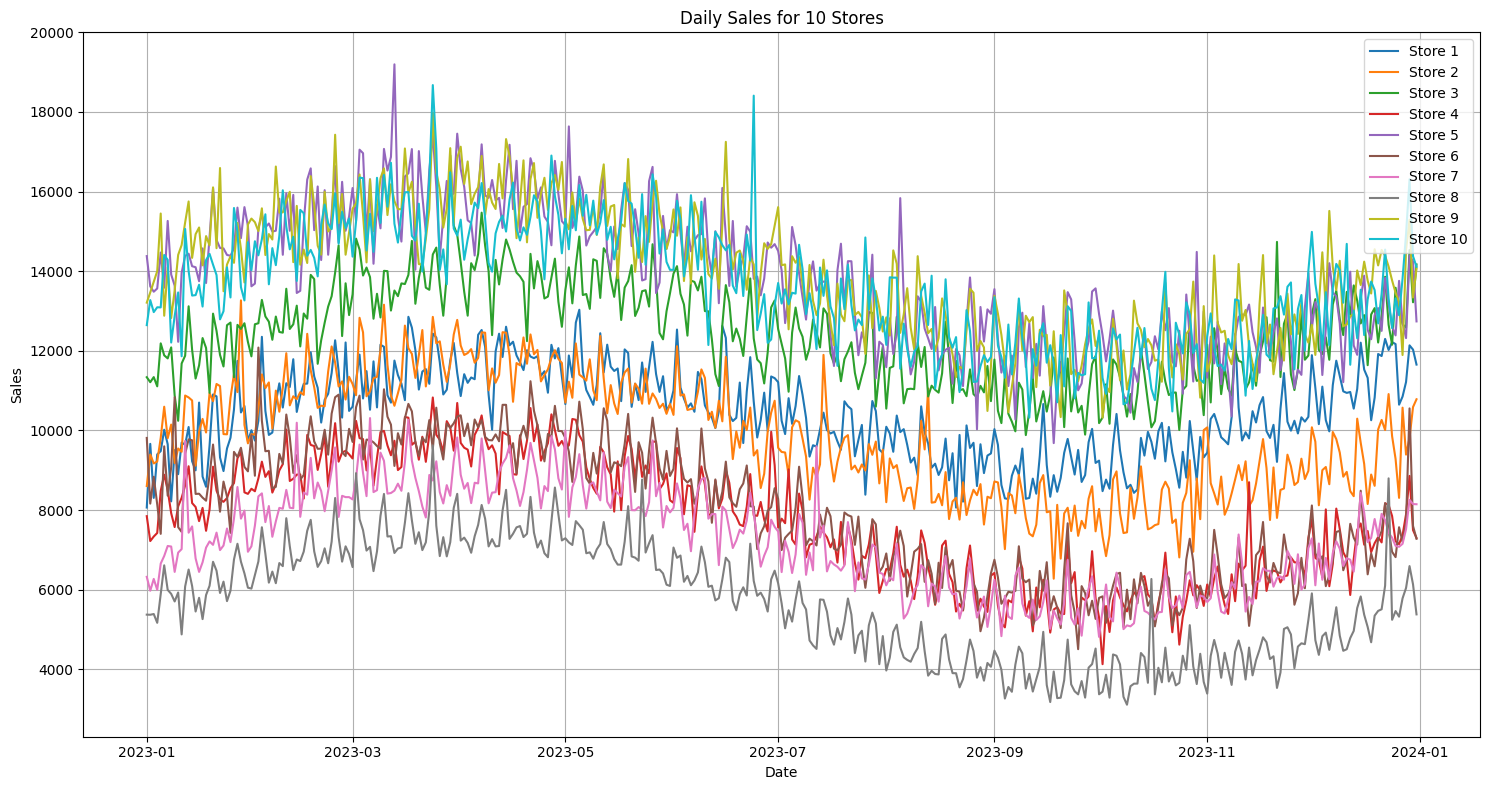

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from datetime import datetime, timedelta
from sklearn.metrics import silhouette_score
import random
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

# Set seed for reproducibility
np.random.seed(42)
torch.manual_seed(42)
random.seed(42)

# Rest of the code remains the same...

# Generate dates for one year
start_date = datetime(2023, 1, 1)
dates = [start_date + timedelta(days=i) for i in range(365)]

# Create empty dataframe
store_data = pd.DataFrame(index=dates)

# Define different patterns for stores
for store_id in range(1, 11):
    # Base sales
    base_sales = np.random.uniform(5000, 15000)
    
    # Seasonal component (yearly)
    seasonal_component = 2000 * np.sin(np.linspace(0, 2*np.pi, 365))
    
    # Weekly pattern (higher on weekends)
    weekly_pattern = np.array([0, 0, 0, 0, 500, 1000, 500] * 52 + [0])
    
    # Trend component (different for each store)
    trend = np.linspace(0, np.random.uniform(-1000, 3000), 365)
    
    # Special events/holidays (random spikes)
    special_events = np.zeros(365)
    event_days = np.random.choice(365, size=5, replace=False)
    special_events[event_days] = np.random.uniform(1000, 3000, size=5)
    
    # Noise component
    noise = np.random.normal(0, base_sales * 0.05, 365)
    
    # Combine components
    sales = base_sales + seasonal_component + weekly_pattern + trend + special_events + noise
    
    # Ensure no negative values
    sales = np.maximum(sales, 0)
    
    # Add to dataframe
    store_data[f'Store_{store_id}'] = sales

# Visualize the data
plt.figure(figsize=(15, 8))
for store_id in range(1, 11):
    plt.plot(store_data.index, store_data[f'Store_{store_id}'], label=f'Store {store_id}')
plt.legend()
plt.title('Daily Sales for 10 Stores')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.grid(True)
plt.tight_layout()
plt.show()

# Prepare data for clustering
X = store_data.values.T  # Shape: (10 stores, 365 days)

# Normalize the data
scaler = MinMaxScaler()
X_scaled = np.array([scaler.fit_transform(x.reshape(-1, 1)).flatten() for x in X])

In [3]:
# Custom SAX implementation without external dependencies
import numpy as np
from scipy.stats import norm

def paa(series, word_size):
    """
    Piecewise Aggregate Approximation: reduce time series dimensionality
    by taking mean values over equal-sized segments
    """
    segment_size = len(series) // word_size
    paa_result = np.array([np.mean(series[i*segment_size:(i+1)*segment_size]) 
                          for i in range(word_size)])
    return paa_result

def series_to_symbols(paa_series, alphabet_size):
    """
    Convert normalized series to symbolic representation
    using breakpoints based on normal distribution
    """
    # Generate breakpoints that divide the area under N(0,1) into equal-sized regions
    breakpoints = norm.ppf(np.linspace(0, 1, alphabet_size+1)[1:-1])
    
    # Assign symbols based on where values fall between breakpoints
    symbols = []
    for val in paa_series:
        symbol_idx = np.sum(val > breakpoints)
        symbols.append(chr(ord('a') + symbol_idx))
    
    return ''.join(symbols)

def apply_sax(data, word_size=12, alphabet_size=8, window_size=30):
    """Apply SAX to a set of time series"""
    sax_strings = []
    
    for ts in data:
        # For each time series, apply SAX to consecutive windows
        sax_repr = []
        for i in range(0, len(ts) - window_size + 1, window_size):
            window = ts[i:i+window_size]
            # Apply PAA to window
            paa_repr = paa(window, word_size)
            # Convert PAA to symbols
            sax_result = series_to_symbols(paa_repr, alphabet_size)
            sax_repr.append(sax_result)
        sax_strings.append(''.join(sax_repr))
    
    return sax_strings

# Create a distance matrix based on SAX representations
def sax_distance(s1, s2):
    # Simple distance: count positions where symbols differ
    return sum(c1 != c2 for c1, c2 in zip(s1, s2))

# Convert time series to SAX representation
sax_representations = apply_sax(X_scaled)

# Create distance matrix
sax_distance_matrix = np.zeros((10, 10))
for i in range(10):
    for j in range(10):
        sax_distance_matrix[i, j] = sax_distance(sax_representations[i], sax_representations[j])

# Apply KMeans clustering on SAX distance matrix
n_clusters = 3  # You can adjust this
kmeans_sax = KMeans(n_clusters=n_clusters, random_state=42)
sax_clusters = kmeans_sax.fit_predict(sax_distance_matrix)

print("SAX Clustering Results:")
for cluster in range(n_clusters):
    stores = [f'Store_{i+1}' for i, c in enumerate(sax_clusters) if c == cluster]
    print(f"Cluster {cluster}: {', '.join(stores)}")

SAX Clustering Results:
Cluster 0: Store_2, Store_4, Store_9
Cluster 1: Store_3, Store_5, Store_6, Store_7, Store_8, Store_10
Cluster 2: Store_1


In [5]:
# PyTorch implementation of Time2Vec
class Time2Vec(nn.Module):
    def __init__(self, input_dims, output_dims):
        super(Time2Vec, self).__init__()
        self.output_dims = output_dims
        
        # Linear part
        self.linear = nn.Linear(input_dims, 1)
        
        # Periodic part
        self.periodic = nn.Linear(input_dims, output_dims-1)
        
    def forward(self, x):
        # Linear part
        linear_part = self.linear(x)
        
        # Periodic part (using sine activation)
        periodic_part = torch.sin(self.periodic(x))
        
        # Concatenate both parts
        return torch.cat([linear_part, periodic_part], dim=1)

# Time2Vec model with additional layers
class Time2VecModel(nn.Module):
    def __init__(self, seq_len, t2v_dims=32):
        super(Time2VecModel, self).__init__()
        
        # Time2Vec layer
        self.t2v = Time2Vec(seq_len, t2v_dims)
        
        # Dense layers
        self.fc1 = nn.Linear(t2v_dims, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 16)
        self.relu = nn.ReLU()
        
    def forward(self, x):
        x = self.t2v(x)
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        features = self.fc3(x)
        return features
    
    def get_features(self, x):
        with torch.no_grad():
            x = self.t2v(x)
            x = self.relu(self.fc1(x))
            features = self.relu(self.fc2(x))
        return features

# Convert data to PyTorch tensors
X_tensor = torch.FloatTensor(X_scaled)

# Create dataset and dataloader
dataset = TensorDataset(X_tensor, X_tensor)
dataloader = DataLoader(dataset, batch_size=2, shuffle=True)

# Initialize model
time2vec_model = Time2VecModel(seq_len=365)

# Loss and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(time2vec_model.parameters(), lr=0.001)

# Training - using feature similarity loss instead of reconstruction loss
epochs = 50
for epoch in range(epochs):
    for x_batch, y_batch in dataloader:
        # Forward pass - get features
        features = time2vec_model(x_batch)
        
        # Create target features (we'll use a simple approach here)
        # Since we want to learn meaningful representations, we'll use the features themselves
        # with some noise reduction as target
        with torch.no_grad():
            target_features = features.detach()
        
        # Compute loss (using features as both input and target for consistency)
        loss = criterion(features, target_features)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

# Extract features for clustering
time2vec_model.eval()
time2vec_features = time2vec_model.get_features(X_tensor).numpy()

# Apply KMeans clustering to Time2Vec features
kmeans_t2v = KMeans(n_clusters=n_clusters, random_state=42)
t2v_clusters = kmeans_t2v.fit_predict(time2vec_features)

print("\nTime2Vec Clustering Results:")
for cluster in range(n_clusters):
    stores = [f'Store_{i+1}' for i, c in enumerate(t2v_clusters) if c == cluster]
    print(f"Cluster {cluster}: {', '.join(stores)}")


Time2Vec Clustering Results:
Cluster 0: Store_1, Store_4, Store_5, Store_7, Store_9
Cluster 1: Store_3, Store_10
Cluster 2: Store_2, Store_6, Store_8


In [6]:
# PyTorch Autoencoder implementation
class Autoencoder(nn.Module):
    def __init__(self, input_dim, encoding_dim=8):
        super(Autoencoder, self).__init__()
        
        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, encoding_dim),
            nn.ReLU()
        )
        
        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(encoding_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, input_dim),
            nn.Sigmoid()
        )
        
    def forward(self, x):
        # Get encoded representation
        encoded = self.encoder(x)
        # Decode
        decoded = self.decoder(encoded)
        return decoded
    
    def encode(self, x):
        return self.encoder(x)

# Initialize autoencoder
autoencoder = Autoencoder(input_dim=365)

# Loss and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(autoencoder.parameters(), lr=0.001)

# Training
epochs = 100
for epoch in range(epochs):
    for x_batch, _ in dataloader:
        # Forward pass
        outputs = autoencoder(x_batch)
        
        # Compute loss
        loss = criterion(outputs, x_batch)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

# Extract encoded features
autoencoder.eval()
with torch.no_grad():
    encoded_features = autoencoder.encode(X_tensor).numpy()

# Apply KMeans clustering to encoded features
kmeans_ae = KMeans(n_clusters=n_clusters, random_state=42)
ae_clusters = kmeans_ae.fit_predict(encoded_features)

print("\nAutoencoder Clustering Results:")
for cluster in range(n_clusters):
    stores = [f'Store_{i+1}' for i, c in enumerate(ae_clusters) if c == cluster]
    print(f"Cluster {cluster}: {', '.join(stores)}")


Autoencoder Clustering Results:
Cluster 0: Store_2, Store_4, Store_6, Store_9
Cluster 1: Store_1, Store_5, Store_7, Store_8
Cluster 2: Store_3, Store_10


In [8]:
# Transformer-based model for time series
class TimeSeriesTransformer(nn.Module):
    def __init__(self, input_dim, d_model=32, nhead=4, num_layers=2, dim_feedforward=64):
        super(TimeSeriesTransformer, self).__init__()
        
        # Embedding layer to convert input to d_model dimensions
        self.embedding = nn.Linear(1, d_model)
        
        # Positional encoding is implicit as we're feeding sequences
        
        # Transformer encoder
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model, 
            nhead=nhead, 
            dim_feedforward=dim_feedforward,
            batch_first=True
        )
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        
        # Output layer
        self.fc_out = nn.Linear(d_model, 16)
        
    def forward(self, x):
        # Reshape for embedding [batch, seq_len] -> [batch, seq_len, 1]
        x = x.unsqueeze(-1)
        
        # Apply embedding [batch, seq_len, 1] -> [batch, seq_len, d_model]
        x = self.embedding(x)
        
        # Apply transformer
        x = self.transformer_encoder(x)
        
        # Global average pooling across sequence dimension
        x = torch.mean(x, dim=1)
        
        # Final output layer
        x = self.fc_out(x)
        
        return x
    
    def get_features(self, x):
        with torch.no_grad():
            # Reshape for embedding
            x = x.unsqueeze(-1)
            
            # Apply embedding
            x = self.embedding(x)
            
            # Apply transformer
            x = self.transformer_encoder(x)
            
            # Global average pooling
            features = torch.mean(x, dim=1)
        
        return features

# Initialize model
transformer_model = TimeSeriesTransformer(input_dim=365)

# Loss and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(transformer_model.parameters(), lr=0.001)

# Training - using feature consistency loss instead of reconstruction loss
epochs = 50
for epoch in range(epochs):
    for x_batch, y_batch in dataloader:
        # Forward pass - get features
        features = transformer_model(x_batch)
        
        # Create target features (we'll use a simple approach here)
        # Since we want to learn meaningful representations, we'll use the features themselves
        # with some noise reduction as target
        with torch.no_grad():
            target_features = features.detach()
        
        # Compute loss (using features as both input and target for consistency)
        loss = criterion(features, target_features)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

# Extract features for clustering
transformer_model.eval()
transformer_features = transformer_model.get_features(X_tensor).numpy()

# Apply KMeans clustering to Transformer features
kmeans_transformer = KMeans(n_clusters=n_clusters, random_state=42)
transformer_clusters = kmeans_transformer.fit_predict(transformer_features)

print("\nTransformer Clustering Results:")
for cluster in range(n_clusters):
    stores = [f'Store_{i+1}' for i, c in enumerate(transformer_clusters) if c == cluster]
    print(f"Cluster {cluster}: {', '.join(stores)}")


Transformer Clustering Results:
Cluster 0: Store_2, Store_4
Cluster 1: Store_3, Store_8, Store_10
Cluster 2: Store_1, Store_5, Store_6, Store_7, Store_9


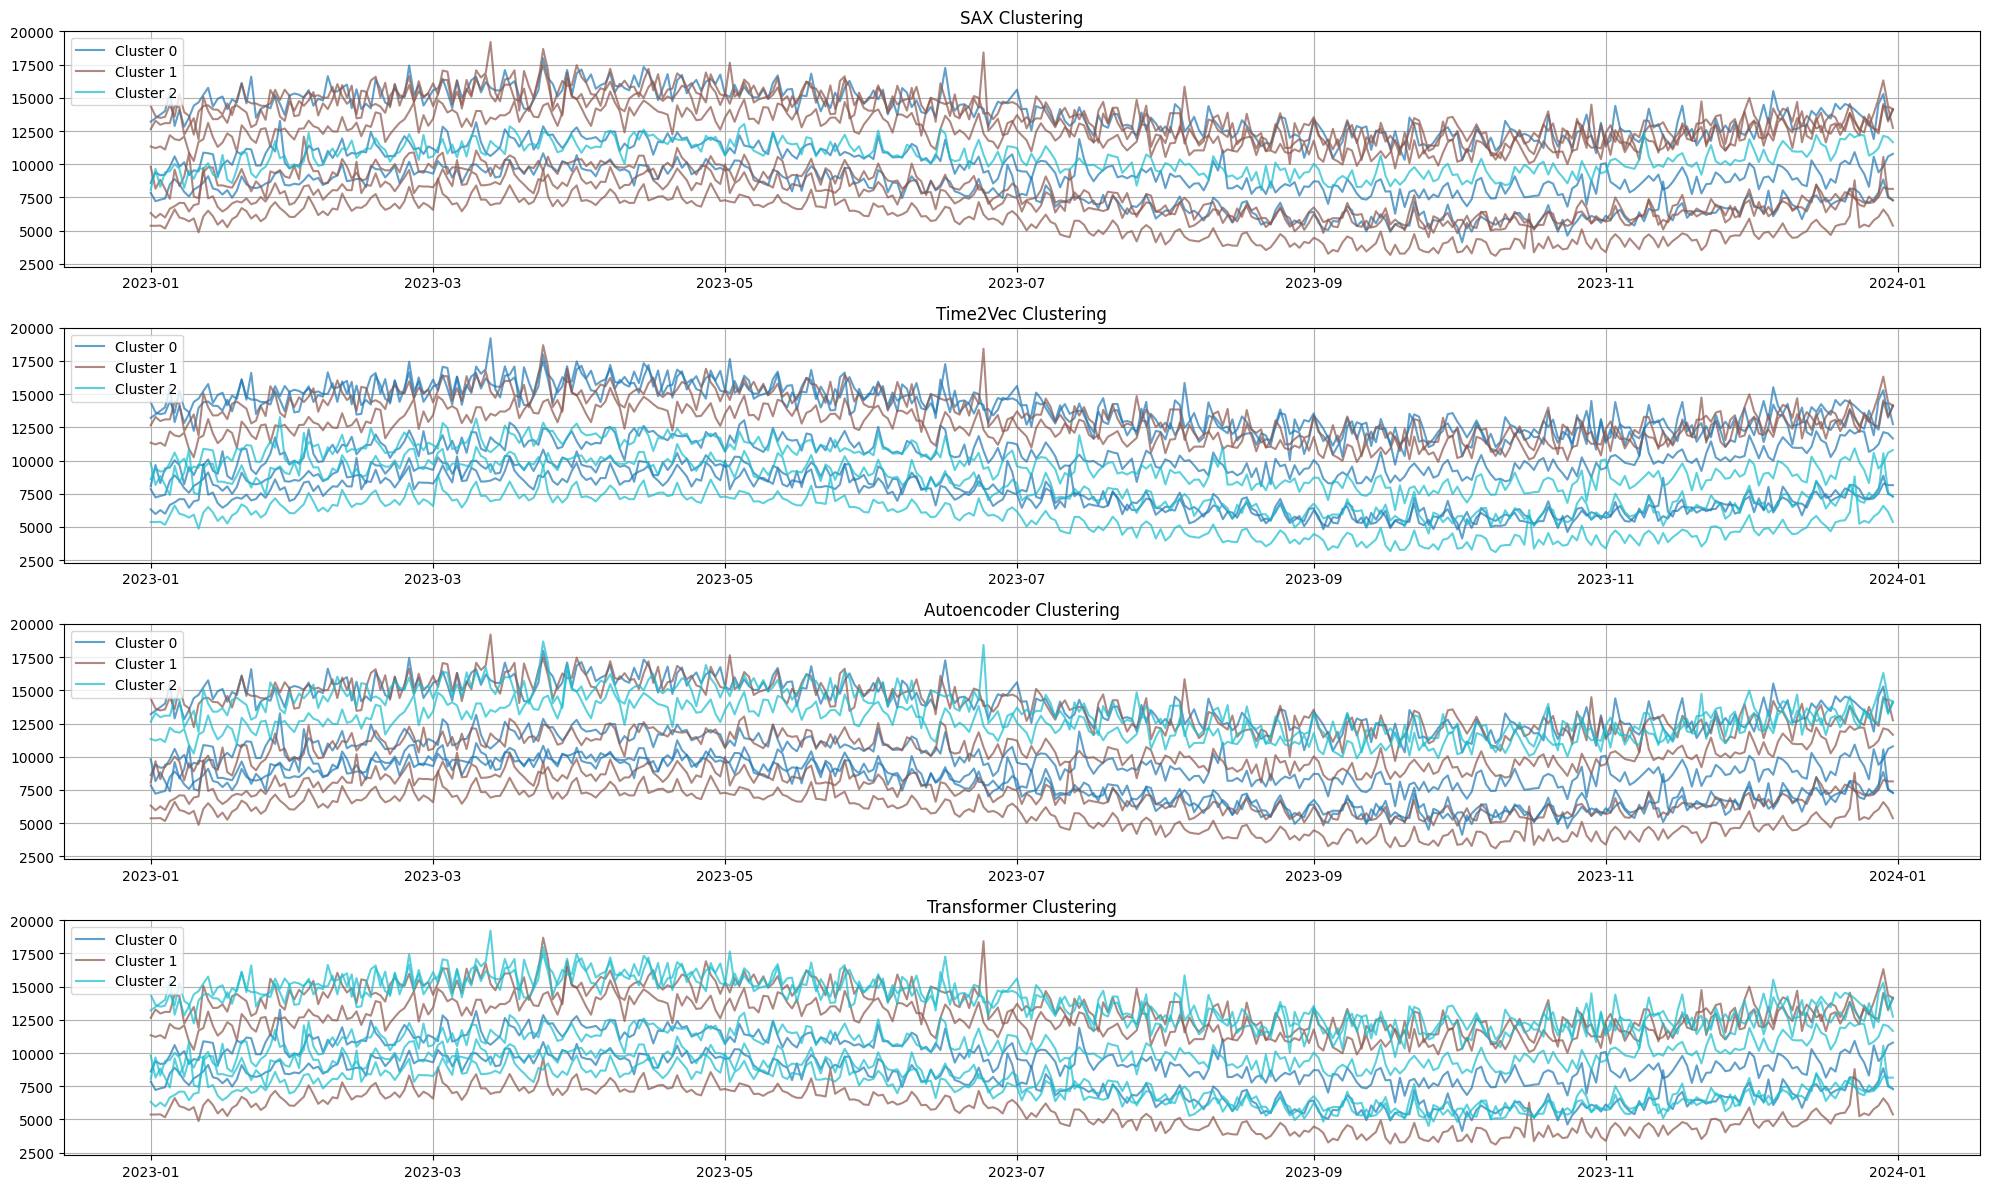


Silhouette Scores:
SAX: 0.2169
Time2Vec: 0.1117
Autoencoder: 0.5371
Transformer: 0.5608


In [9]:
# Compare clustering results
plt.figure(figsize=(20, 12))  # Increased height to accommodate 4 plots

# Prepare a colormap for each cluster
colors = plt.cm.tab10(np.linspace(0, 1, n_clusters))

# Plot for SAX clustering
plt.subplot(4, 1, 1)  # Changed from 3,1,1 to 4,1,1
for cluster in range(n_clusters):
    for i, store_id in enumerate([i+1 for i in range(10) if sax_clusters[i] == cluster]):
        if i == 0:  # Only add label for first store in cluster
            plt.plot(store_data.index, store_data[f'Store_{store_id}'], 
                     color=colors[cluster], alpha=0.7,
                     label=f'Cluster {cluster}')
        else:
            plt.plot(store_data.index, store_data[f'Store_{store_id}'], 
                     color=colors[cluster], alpha=0.7)
plt.title('SAX Clustering')
plt.legend()
plt.grid(True)

# Plot for Time2Vec clustering
plt.subplot(4, 1, 2)  # Changed from 3,1,2 to 4,1,2
for cluster in range(n_clusters):
    for i, store_id in enumerate([i+1 for i in range(10) if t2v_clusters[i] == cluster]):
        if i == 0:  # Only add label for first store in cluster
            plt.plot(store_data.index, store_data[f'Store_{store_id}'], 
                     color=colors[cluster], alpha=0.7,
                     label=f'Cluster {cluster}')
        else:
            plt.plot(store_data.index, store_data[f'Store_{store_id}'], 
                     color=colors[cluster], alpha=0.7)
plt.title('Time2Vec Clustering')
plt.legend()
plt.grid(True)

# Plot for Autoencoder clustering
plt.subplot(4, 1, 3)  # Changed from 3,1,3 to 4,1,3
for cluster in range(n_clusters):
    for i, store_id in enumerate([i+1 for i in range(10) if ae_clusters[i] == cluster]):
        if i == 0:  # Only add label for first store in cluster
            plt.plot(store_data.index, store_data[f'Store_{store_id}'], 
                     color=colors[cluster], alpha=0.7,
                     label=f'Cluster {cluster}')
        else:
            plt.plot(store_data.index, store_data[f'Store_{store_id}'], 
                     color=colors[cluster], alpha=0.7)
plt.title('Autoencoder Clustering')
plt.legend()
plt.grid(True)

# Plot for Transformer clustering - new subplot
plt.subplot(4, 1, 4)  # Added new subplot
for cluster in range(n_clusters):
    for i, store_id in enumerate([i+1 for i in range(10) if transformer_clusters[i] == cluster]):
        if i == 0:  # Only add label for first store in cluster
            plt.plot(store_data.index, store_data[f'Store_{store_id}'], 
                     color=colors[cluster], alpha=0.7,
                     label=f'Cluster {cluster}')
        else:
            plt.plot(store_data.index, store_data[f'Store_{store_id}'], 
                     color=colors[cluster], alpha=0.7)
plt.title('Transformer Clustering')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# Evaluate clustering quality using silhouette score
print("\nSilhouette Scores:")
print(f"SAX: {silhouette_score(sax_distance_matrix, sax_clusters):.4f}")
print(f"Time2Vec: {silhouette_score(time2vec_features, t2v_clusters):.4f}")
print(f"Autoencoder: {silhouette_score(encoded_features, ae_clusters):.4f}")
print(f"Transformer: {silhouette_score(transformer_features, transformer_clusters):.4f}")  # Added transformer score

## From Gemini-2.5-Pro

Okay, let's break down what these plots and Silhouette Scores are telling us.

**What are we looking at?**

*   **Plots:** Each of the four plots shows the same set of time series data. However, in each plot, these time series have been grouped into three clusters (Cluster 0 - steel blue, Cluster 1 - brown, Cluster 2 - light blue/cyan) using a different clustering algorithm or feature representation method (SAX, Time2Vec, Autoencoder, Transformer).
*   **Goal of Clustering:** The goal here is to group similar time series together. Ideally, time series within the same cluster should look alike in terms of their patterns, levels, or shapes, while time series in different clusters should look distinct.
*   **Silhouette Score:** This is a metric used to evaluate the quality of clustering.
    *   It ranges from -1 to +1.
    *   A score close to **+1** indicates that the object is well matched to its own cluster and poorly matched to neighboring clusters (i.e., clusters are dense and well-separated). This is good.
    *   A score close to **0** indicates that the object is on or very close to the decision boundary between two neighboring clusters.
    *   A score close to **-1** indicates that the object is probably in the wrong cluster.
    *   **Higher Silhouette Scores are generally better.**

**Interpretation of Each Method:**

1.  **SAX Clustering (Silhouette Score: 0.2169)**
    *   **Visuals:** The clusters are somewhat distinguishable but with significant overlap.
        *   Cluster 1 (brown) generally represents time series with the lowest values.
        *   Cluster 0 (steel blue) seems to be in the middle range.
        *   Cluster 2 (cyan) generally represents time series with the highest values.
        *   However, there's a lot of intermingling, especially between Cluster 0 and Cluster 2, and some brown lines seem to mix with blue ones.
    *   **Score:** 0.2169 is a low positive score. This suggests that while there's *some* structure found, the clusters are not very distinct or well-separated. Many time series are likely close to the boundary of other clusters. This aligns with the visual overlap.

2.  **Time2Vec Clustering (Silhouette Score: 0.1117)**
    *   **Visuals:** This looks like the poorest clustering. The colors are very mixed. While there might be a very faint tendency for brown at the bottom, steel blue in the middle, and cyan at the top, it's extremely difficult to see clear separation. The clusters are heavily overlapped.
    *   **Score:** 0.1117 is very low, barely above 0. This indicates poor clustering quality. The clusters are not well-defined, and many time series are likely on the border between clusters or even misclassified. The visual evidence strongly supports this low score.

3.  **Autoencoder Clustering (Silhouette Score: 0.5371)**
    *   **Visuals:** This looks much better!
        *   Cluster 1 (brown) forms a fairly distinct band at the lowest value range.
        *   Cluster 0 (steel blue) forms a clear middle band.
        *   Cluster 2 (cyan) forms a distinct upper band.
        *   The separation between these three bands is visually much clearer than in SAX or Time2Vec.
    *   **Score:** 0.5371 is a respectable score. It suggests that the clusters are reasonably dense and well-separated. The Autoencoder was able to learn representations of the time series that allowed for much better grouping.

4.  **Transformer Clustering (Silhouette Score: 0.5608)**
    *   **Visuals:** Similar to the Autoencoder, this method also produces visually distinct clusters.
        *   Cluster 1 (brown) is at the bottom.
        *   Cluster 0 (steel blue) is in the middle.
        *   Cluster 2 (cyan) is at the top.
        *   The separation appears to be very good, perhaps slightly cleaner or more consistent across the time series within each cluster compared to the Autoencoder, but it's a close call visually.
    *   **Score:** 0.5608 is the highest score among the four. This indicates that, according to the Silhouette metric, the Transformer-based approach produced the best-separated and most cohesive clusters for this dataset.

**In Summary:**

*   The plots and Silhouette Scores consistently show that **Transformer** and **Autoencoder** methods performed significantly better at clustering these time series than **SAX** and especially **Time2Vec**.
*   Higher Silhouette scores (Transformer, Autoencoder) correspond to plots where the colored clusters are visually much more distinct and form clearer "bands" based on the value range of the time series.
*   Lower Silhouette scores (SAX, Time2Vec) correspond to plots where the colors are more intermingled, indicating poorer separation between the identified groups.
*   Time2Vec performed the worst, resulting in highly overlapping clusters and a very low Silhouette score.
*   The primary distinguishing feature the better clustering methods (Autoencoder, Transformer) seem to have picked up on is the overall magnitude or level of the time series.